In [32]:
import os
import sys
from pathlib import Path

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torch.optim as optim

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
from sklearn.feature_extraction.text import CountVectorizer , TfidfVectorizer

from scipy import sparse

from transformers import BertTokenizer, BertModel

cwd = Path.cwd()
if (cwd / "functions").exists():
    functions_dir = cwd / "functions"
else:
    functions_dir = cwd / "Q2" / "functions"

sys.path.insert(0, str(functions_dir))

from mlp_utils import train,predict_proba
from eval_utils import evaluate_model  # detailed plots + ROC

# Reproducibility
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


In [33]:
if (cwd / "train_df_processed.csv").exists():
    train_path = cwd / "train_df_processed.csv"
    test_path = cwd / "test_df_processed.csv"
else:
    train_path = cwd.parent / "train_df_processed.csv"
    test_path = cwd.parent / "test_df_processed.csv"

train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

# Basic safety
train_df = train_df.dropna(subset=["processed_text", "sentiment_class"])
test_df = test_df.dropna(subset=["processed_text", "sentiment_class"])

print("train_df:", train_df.shape)
print("test_df :", test_df.shape)
train_df.head()

train_df: (27463, 12)
test_df : (3531, 11)


,textID,text,selected_text,sentiment,Time of Tweet,Age of User,Country,Population -2020,Land Area (Km²),Density (P/Km²),processed_text,sentiment_class
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,morning,0-20,Afghanistan,38928346,652860.0,60,"i`d responded, going",1
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,noon,21-30,Albania,2877797,27400.0,105,sooo sad miss san diego!!!,0
2,088c60f138,my boss is bullying me...,bullying me,negative,night,31-45,Algeria,43851044,2381740.0,18,boss bullying me...,0
3,9642c003ef,what interview! leave me alone,leave me alone,negative,morning,46-60,Andorra,77265,470.0,164,interview! leave alone,0
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,noon,60-70,Angola,32866272,1246700.0,26,"sons ****, couldn`t put releases already bought",0


## Train/Val split (stratified)

In [34]:
X_train_text = train_df["processed_text"].astype(str).values
y_train = train_df["sentiment_class"].astype(int).values


X_test_text = test_df["processed_text"].astype(str).values
y_test = test_df["sentiment_class"].astype(int).values

print("Train size:", len(X_train_text))
print("Test size :", len(X_test_text))


Train size: 27463
Test size : 3531


# Vectorization: Char

In [35]:
MAX_LENGTH = 128
NUM_CLASSES = 3
vectorizer = TfidfVectorizer(
    analyzer='char_wb',
    max_df=0.9,
    min_df=1,
    max_features=10000,
    ngram_range=(3, 5)
)

X_train_vec = vectorizer.fit_transform(X_train_text)
X_test_vec = vectorizer.transform(X_test_text)

In [36]:
class SparseBoWDataset(Dataset):
    def __init__(self, X_sparse, y):
        self.X = X_sparse.tocsr()
        self.y = y

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    
def collate_sparse(batch):
    xs, ys = zip(*batch)
    x_batch = sparse.vstack(xs).toarray().astype(np.float32)
    y_batch = np.array(ys, dtype=np.int64)
    return {"x": torch.from_numpy(x_batch), "label": torch.from_numpy(y_batch)}

In [37]:
train_dataset = SparseBoWDataset(X_train_vec, y_train)
test_dataset = SparseBoWDataset(X_test_vec, y_test)

MLP_BATCH_SIZE = 128
train_loader = DataLoader(
    train_dataset,
    batch_size=MLP_BATCH_SIZE,
    shuffle=True,
    collate_fn=collate_sparse
)


test_loader = DataLoader(
    test_dataset,
    batch_size=MLP_BATCH_SIZE,  
    shuffle=False,
    collate_fn=collate_sparse
)


## MLP's structure definition

In [38]:
INPUT_DIM = X_train_vec.shape[1]
print(INPUT_DIM)
# 1) INPUT_DIM -> 1024 -> 512 -> 256 -> NUM_CLASSES, dropout 0.3, ReLU
class MLP_1024_512_256_drop0_3(nn.Module):
    def __init__(self):
        super(MLP_1024_512_256_drop0_3, self).__init__()
        self.linear1 = nn.Linear(INPUT_DIM, 1024)
        self.linear2 = nn.Linear(1024, 512)
        self.linear3 = nn.Linear(512, 256)
        self.final   = nn.Linear(256, NUM_CLASSES)
        self.drop    = nn.Dropout(0.3)

    def forward(self, x):
        x = x.view(-1, INPUT_DIM)
        x = F.relu(self.linear1(x))
        x = self.drop(x)
        x = F.relu(self.linear2(x))
        x = self.drop(x)
        x = F.relu(self.linear3(x))
        x = self.drop(x)
        x = self.final(x)
        return x


# 2) INPUT_DIM -> 2048 -> 1024 -> 512 -> NUM_CLASSES, dropout 0.2, GELU
class MLP_2048_1024_512_drop0_2_gelu(nn.Module):
    def __init__(self):
        super(MLP_2048_1024_512_drop0_2_gelu, self).__init__()
        self.linear1 = nn.Linear(INPUT_DIM, 2048)
        self.linear2 = nn.Linear(2048, 1024)
        self.linear3 = nn.Linear(1024, 512)
        self.final   = nn.Linear(512, NUM_CLASSES)
        self.drop    = nn.Dropout(0.2)

    def forward(self, x):
        x = x.view(-1, INPUT_DIM)
        x = F.gelu(self.linear1(x))
        x = self.drop(x)
        x = F.gelu(self.linear2(x))
        x = self.drop(x)
        x = F.gelu(self.linear3(x))
        x = self.drop(x)
        x = self.final(x)
        return x


# 3) INPUT_DIM -> 1536 -> 768 -> 384 -> 192 -> NUM_CLASSES, dropout 0.25, SiLU
class MLP_1536_768_384_192_drop0_25_silu(nn.Module):
    def __init__(self):
        super(MLP_1536_768_384_192_drop0_25_silu, self).__init__()
        self.linear1 = nn.Linear(INPUT_DIM, 1536)
        self.linear2 = nn.Linear(1536, 768)
        self.linear3 = nn.Linear(768, 384)
        self.linear4 = nn.Linear(384, 192)
        self.final   = nn.Linear(192, NUM_CLASSES)
        self.drop    = nn.Dropout(0.25)

    def forward(self, x):
        x = x.view(-1, INPUT_DIM)
        x = F.silu(self.linear1(x))
        x = self.drop(x)
        x = F.silu(self.linear2(x))
        x = self.drop(x)
        x = F.silu(self.linear3(x))
        x = self.drop(x)
        x = F.silu(self.linear4(x))
        x = self.drop(x)
        x = self.final(x)
        return x


# 4) INPUT_DIM -> 4096 -> 2048 -> 1024 -> NUM_CLASSES, dropout 0.1, ReLU
class MLP_4096_2048_1024_drop0_1(nn.Module):
    def __init__(self):
        super(MLP_4096_2048_1024_drop0_1, self).__init__()
        self.linear1 = nn.Linear(INPUT_DIM, 4096)
        self.linear2 = nn.Linear(4096, 2048)
        self.linear3 = nn.Linear(2048, 1024)
        self.final   = nn.Linear(1024, NUM_CLASSES)
        self.drop    = nn.Dropout(0.1)

    def forward(self, x):
        x = x.view(-1, INPUT_DIM)
        x = F.relu(self.linear1(x))
        x = self.drop(x)
        x = F.relu(self.linear2(x))
        x = self.drop(x)
        x = F.relu(self.linear3(x))
        x = self.drop(x)
        x = self.final(x)
        return x


model1 = MLP_1024_512_256_drop0_3().to(device)
model2 = MLP_2048_1024_512_drop0_2_gelu().to(device)
model3 = MLP_1536_768_384_192_drop0_25_silu().to(device)
model4 = MLP_4096_2048_1024_drop0_1().to(device)

10000


In [39]:
criterion = nn.CrossEntropyLoss()
nbepoch = 50
lr = 1e-4
optimizer1 = optim.Adam(model1.parameters(), lr=lr)
optimizer2 = optim.Adam(model2.parameters(), lr=lr)
optimizer3 = optim.Adam(model3.parameters(), lr=lr)
optimizer4 = optim.Adam(model4.parameters(), lr=lr)

# Trainning

In [40]:
report_dir = Path("reports") if (cwd / "reports").exists() else (cwd / "Q2" / "reports")
report_dir.mkdir(parents=True, exist_ok=True)

### MLP_1024_512_256_drop0_3

In [41]:
best = float("inf")
patience = 1
wait = 0
outdir = Path("outputs")
mname = "Char_MLP_1024_512_256_drop0_3"
for epoch in range(1, nbepoch + 1):
    tr_loss, tr_acc = train(
    model1, train_loader, optimizer1, criterion,
    epoch, nbepoch, device,
    model_name=mname, output_dir=outdir)
    if tr_loss < best - 1e-4:
        best = tr_loss
        wait = 0
    else:
        wait += 1
        if wait >= patience:
            print("Early stopping (train loss)")
            break
torch.save(model1.state_dict(), outdir / f"{mname}.pt")

| Epoch [  1/ 50] Iter[  1/215]	Loss: 1.0979 Acc@1: 38.281%
| Epoch [  1/ 50] Iter[ 51/215]	Loss: 1.0954 Acc@1: 39.905%
| Epoch [  1/ 50] Iter[101/215]	Loss: 1.0030 Acc@1: 41.553%
| Epoch [  1/ 50] Iter[151/215]	Loss: 0.7603 Acc@1: 46.999%
| Epoch [  1/ 50] Iter[201/215]	Loss: 0.7699 Acc@1: 52.099%
| Epoch [  2/ 50] Iter[  1/215]	Loss: 0.6565 Acc@1: 70.312%
| Epoch [  2/ 50] Iter[ 51/215]	Loss: 0.6813 Acc@1: 73.070%
| Epoch [  2/ 50] Iter[101/215]	Loss: 0.6263 Acc@1: 73.360%
| Epoch [  2/ 50] Iter[151/215]	Loss: 0.6036 Acc@1: 73.303%
| Epoch [  2/ 50] Iter[201/215]	Loss: 0.7919 Acc@1: 73.173%
| Epoch [  3/ 50] Iter[  1/215]	Loss: 0.5804 Acc@1: 75.781%
| Epoch [  3/ 50] Iter[ 51/215]	Loss: 0.6136 Acc@1: 77.037%
| Epoch [  3/ 50] Iter[101/215]	Loss: 0.6185 Acc@1: 76.686%
| Epoch [  3/ 50] Iter[151/215]	Loss: 0.7524 Acc@1: 76.423%
| Epoch [  3/ 50] Iter[201/215]	Loss: 0.6638 Acc@1: 76.244%
| Epoch [  4/ 50] Iter[  1/215]	Loss: 0.5826 Acc@1: 76.562%
| Epoch [  4/ 50] Iter[ 51/215]	Loss: 0.

C:\Users\USER\Documents\ENSTA\4IMO4\LLM-Based-Sentiment-Analysis\Q2\functions\eval_utils.py:54: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(plot_data.values()), y=list(plot_data.keys()), palette='magma', ax=axes[0])


Full report exported successfully: reports/Char_MLP_1024_512_256_drop0_3_Full_Report.png


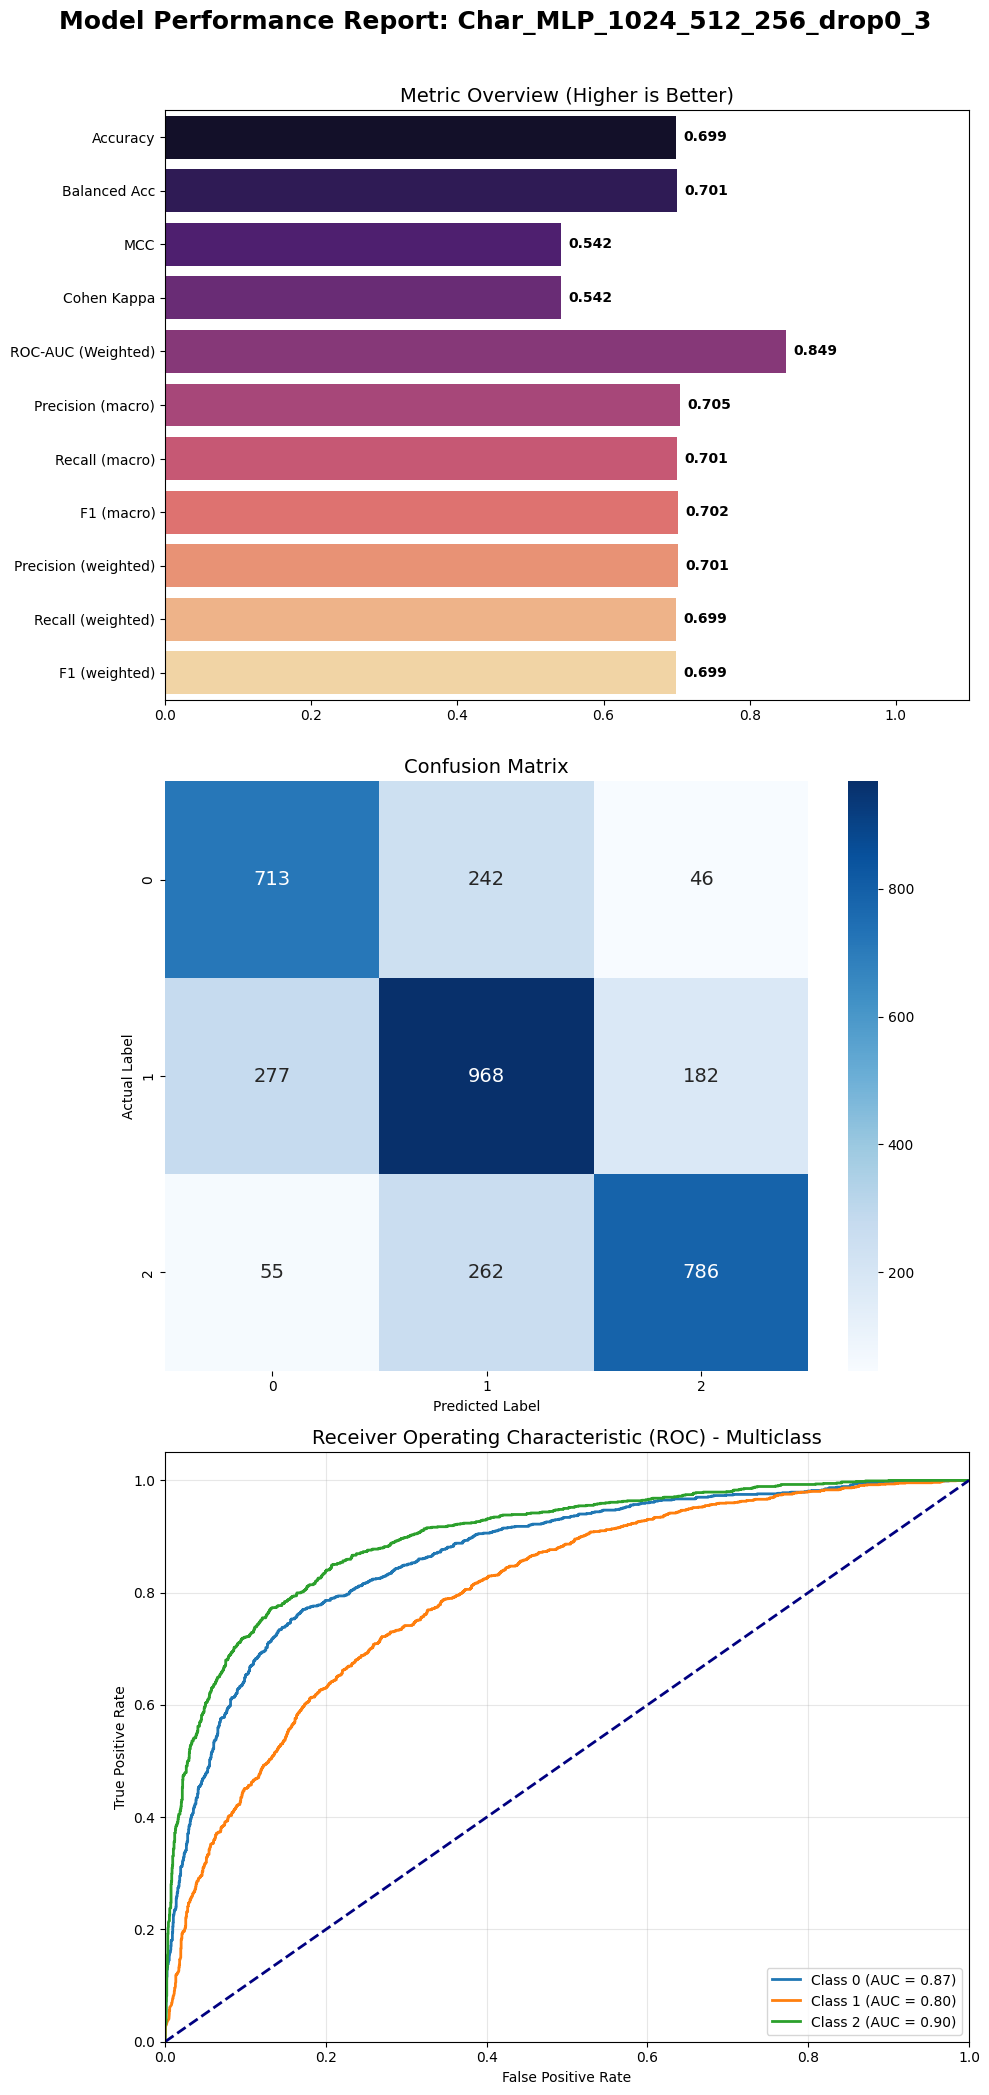

In [42]:
yt_true, yt_pred, yt_probs = predict_proba(model1, test_loader,device)

evaluate_model(
    y_true=yt_true,
    y_pred=yt_pred,
    y_probs=yt_probs,
    model_name="Char_MLP_1024_512_256_drop0_3",
    output_path=str(report_dir),
)

### MLP_2048_1024_512_drop0_2_gelu

In [43]:
best = float("inf")
patience = 1
wait = 0
outdir = Path("outputs")
mname = "Char_MLP_2048_1024_512_drop0_2_gelu"
for epoch in range(1, nbepoch + 1):
    tr_loss, tr_acc = train(
    model2, train_loader, optimizer2, criterion,
    epoch, nbepoch, device,
    model_name=mname, output_dir=outdir)
    if tr_loss < best - 1e-4:
        best = tr_loss
        wait = 0
    else:
        wait += 1
        if wait >= patience:
            print("Early stopping (train loss)")
            break

torch.save(model2.state_dict(), outdir / f"{mname}.pt")

| Epoch [  1/ 50] Iter[  1/215]	Loss: 1.0939 Acc@1: 46.875%
| Epoch [  1/ 50] Iter[ 51/215]	Loss: 1.0849 Acc@1: 40.916%
| Epoch [  1/ 50] Iter[101/215]	Loss: 0.7523 Acc@1: 47.850%
| Epoch [  1/ 50] Iter[151/215]	Loss: 0.6794 Acc@1: 54.377%
| Epoch [  1/ 50] Iter[201/215]	Loss: 0.7388 Acc@1: 58.190%
| Epoch [  2/ 50] Iter[  1/215]	Loss: 0.6379 Acc@1: 75.000%
| Epoch [  2/ 50] Iter[ 51/215]	Loss: 0.6985 Acc@1: 74.341%
| Epoch [  2/ 50] Iter[101/215]	Loss: 0.6533 Acc@1: 73.909%
| Epoch [  2/ 50] Iter[151/215]	Loss: 0.6314 Acc@1: 73.738%
| Epoch [  2/ 50] Iter[201/215]	Loss: 0.6378 Acc@1: 73.644%
| Epoch [  3/ 50] Iter[  1/215]	Loss: 0.5794 Acc@1: 75.781%
| Epoch [  3/ 50] Iter[ 51/215]	Loss: 0.5830 Acc@1: 75.934%
| Epoch [  3/ 50] Iter[101/215]	Loss: 0.5580 Acc@1: 76.067%
| Epoch [  3/ 50] Iter[151/215]	Loss: 0.7179 Acc@1: 75.962%
| Epoch [  3/ 50] Iter[201/215]	Loss: 0.6760 Acc@1: 75.665%
| Epoch [  4/ 50] Iter[  1/215]	Loss: 0.5399 Acc@1: 74.219%
| Epoch [  4/ 50] Iter[ 51/215]	Loss: 0.

C:\Users\USER\Documents\ENSTA\4IMO4\LLM-Based-Sentiment-Analysis\Q2\functions\eval_utils.py:54: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(plot_data.values()), y=list(plot_data.keys()), palette='magma', ax=axes[0])


Full report exported successfully: reports/Char_MLP_2048_1024_512_drop0_2_gelu_Full_Report.png


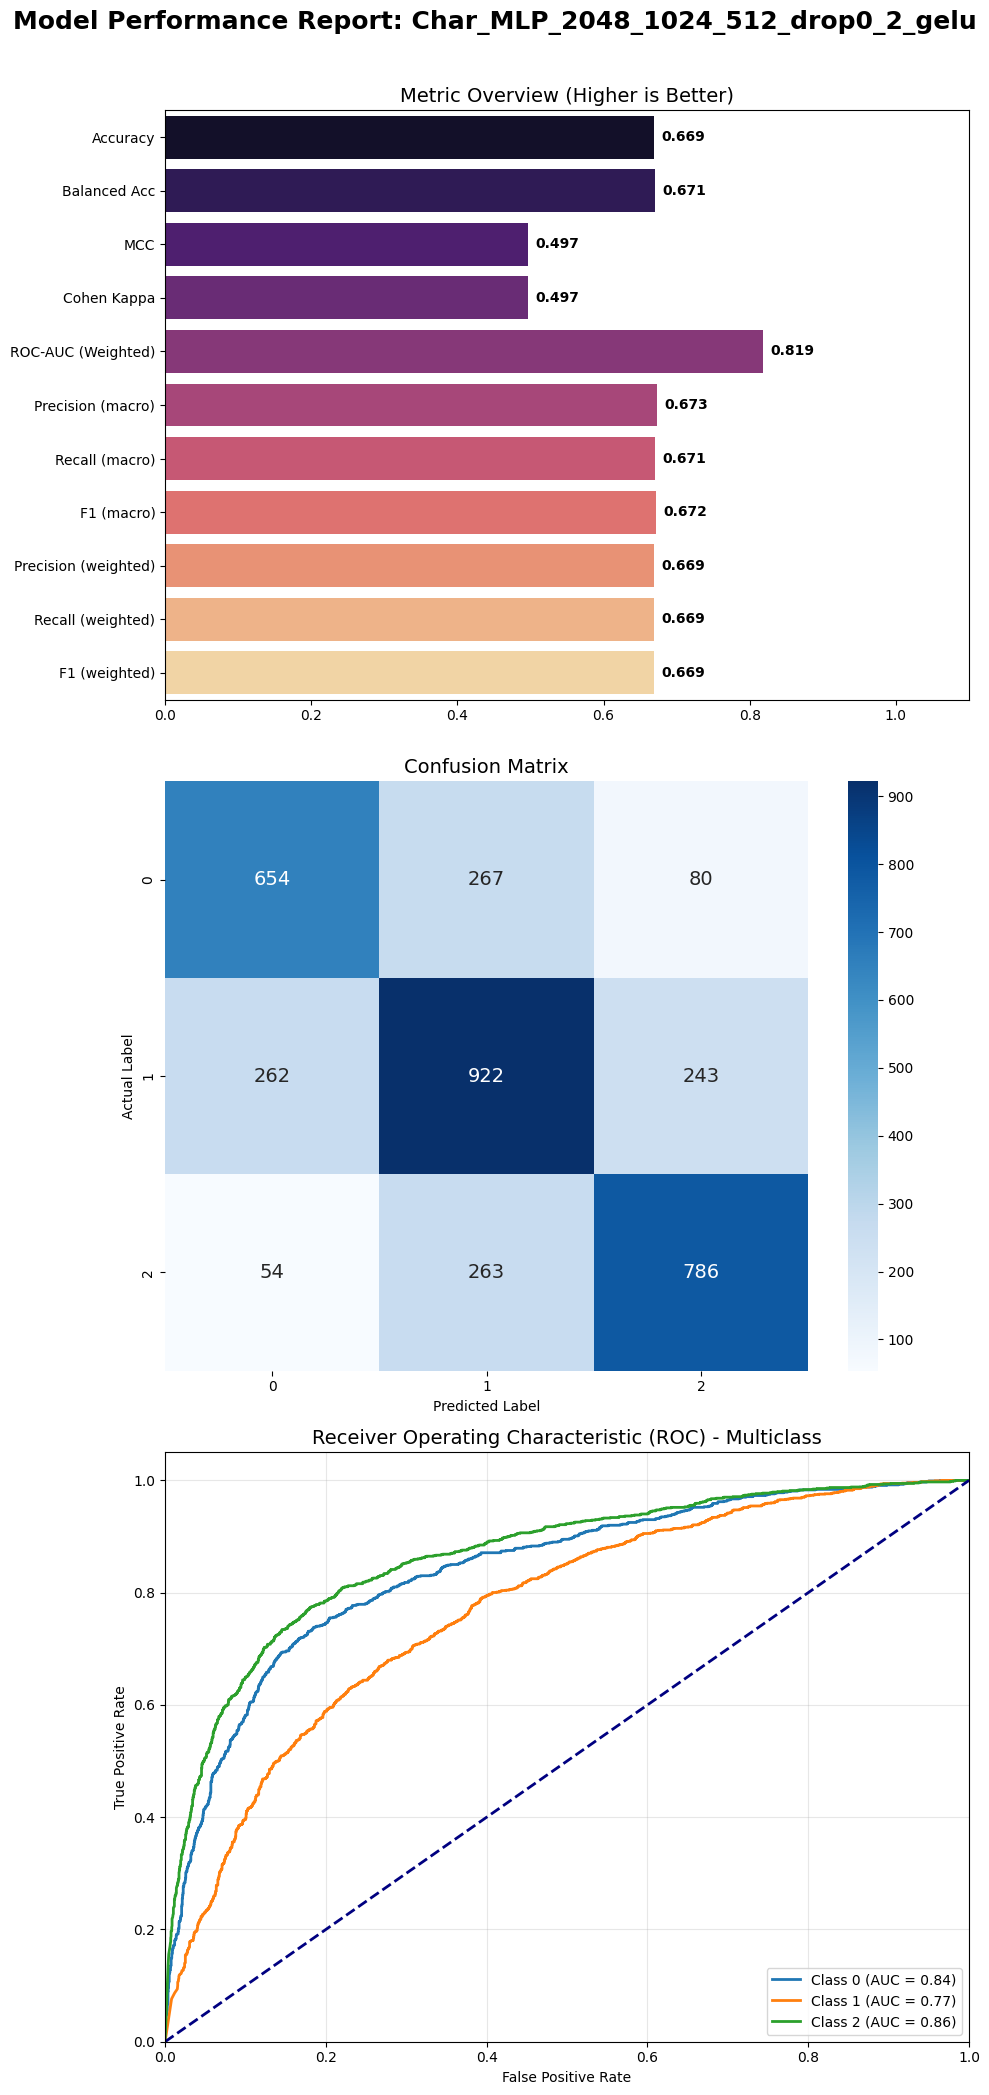

In [44]:
yt_true, yt_pred, yt_probs = predict_proba(model2, test_loader,device)

evaluate_model(
    y_true=yt_true,
    y_pred=yt_pred,
    y_probs=yt_probs,
    model_name="Char_MLP_2048_1024_512_drop0_2_gelu",
    output_path=str(report_dir),
)

### MLP_1536_768_384_192_drop0_25_silu

In [45]:
best = float("inf")
patience = 1
wait = 0
outdir = Path("outputs")
mname = "Char_MLP_1536_768_384_192_drop0_25_silu"
for epoch in range(1, nbepoch + 1):
    tr_loss, tr_acc = train(
    model3, train_loader, optimizer3, criterion,
    epoch, nbepoch, device,
    model_name=mname, output_dir=outdir)
    if tr_loss < best - 1e-4:
        best = tr_loss
        wait = 0
    else:
        wait += 1
        if wait >= patience:
            print("Early stopping (train loss)")
            break

torch.save(model3.state_dict(), outdir / f"{mname}.pt")

| Epoch [  1/ 50] Iter[  1/215]	Loss: 1.0883 Acc@1: 49.219%
| Epoch [  1/ 50] Iter[ 51/215]	Loss: 1.0740 Acc@1: 40.809%
| Epoch [  1/ 50] Iter[101/215]	Loss: 1.0281 Acc@1: 43.897%
| Epoch [  1/ 50] Iter[151/215]	Loss: 0.8781 Acc@1: 49.871%
| Epoch [  1/ 50] Iter[201/215]	Loss: 0.6722 Acc@1: 54.412%
| Epoch [  2/ 50] Iter[  1/215]	Loss: 0.7153 Acc@1: 67.188%
| Epoch [  2/ 50] Iter[ 51/215]	Loss: 0.7346 Acc@1: 73.529%
| Epoch [  2/ 50] Iter[101/215]	Loss: 0.6461 Acc@1: 73.213%
| Epoch [  2/ 50] Iter[151/215]	Loss: 0.6353 Acc@1: 73.200%
| Epoch [  2/ 50] Iter[201/215]	Loss: 0.6588 Acc@1: 73.057%
| Epoch [  3/ 50] Iter[  1/215]	Loss: 0.6189 Acc@1: 76.562%
| Epoch [  3/ 50] Iter[ 51/215]	Loss: 0.4809 Acc@1: 76.011%
| Epoch [  3/ 50] Iter[101/215]	Loss: 0.7011 Acc@1: 75.464%
| Epoch [  3/ 50] Iter[151/215]	Loss: 0.5129 Acc@1: 75.419%
| Epoch [  3/ 50] Iter[201/215]	Loss: 0.6529 Acc@1: 75.393%
| Epoch [  4/ 50] Iter[  1/215]	Loss: 0.6330 Acc@1: 69.531%
| Epoch [  4/ 50] Iter[ 51/215]	Loss: 0.

C:\Users\USER\Documents\ENSTA\4IMO4\LLM-Based-Sentiment-Analysis\Q2\functions\eval_utils.py:54: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(plot_data.values()), y=list(plot_data.keys()), palette='magma', ax=axes[0])


Full report exported successfully: reports/Char_MLP_1536_768_384_192_drop0_25_silu_Full_Report.png


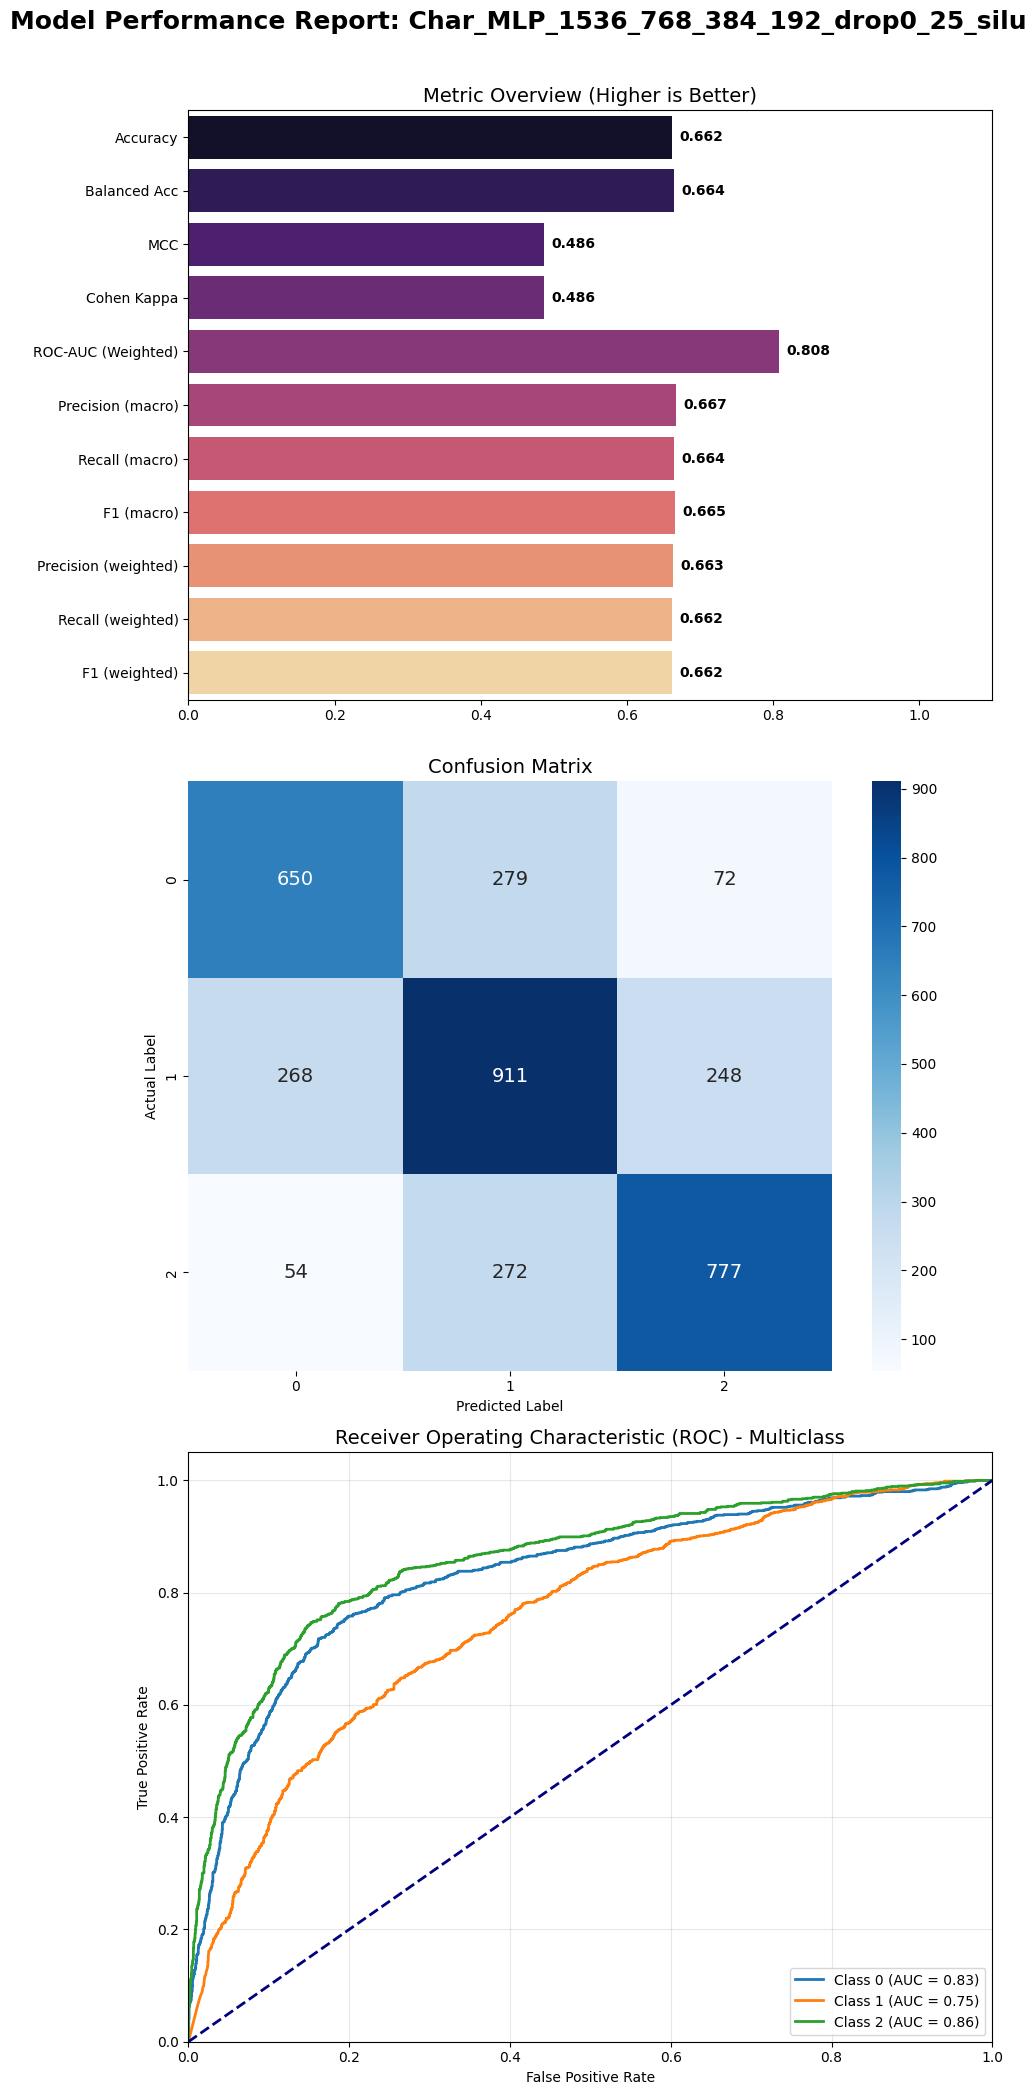

In [46]:
yt_true, yt_pred, yt_probs = predict_proba(model3, test_loader,device)

evaluate_model(
    y_true=yt_true,
    y_pred=yt_pred,
    y_probs=yt_probs,
    model_name="Char_MLP_1536_768_384_192_drop0_25_silu",
    output_path=str(report_dir),
)

### MLP_4096_2048_1024_drop0_1

In [47]:
best = float("inf")
patience = 1
wait = 0
outdir = Path("outputs")
mname = "Char_MLP_4096_2048_1024_drop0_1"
for epoch in range(1, nbepoch + 1):
    tr_loss, tr_acc = train(
    model4, train_loader, optimizer4, criterion,
    epoch, nbepoch, device,
    model_name=mname, output_dir=outdir)
    if tr_loss < best - 1e-4:
        best = tr_loss
        wait = 0
    else:
        wait += 1
        if wait >= patience:
            print("Early stopping (train loss)")
            break

torch.save(model4.state_dict(), outdir / f"{mname}.pt")

| Epoch [  1/ 50] Iter[  1/215]	Loss: 1.0963 Acc@1: 43.750%
| Epoch [  1/ 50] Iter[ 51/215]	Loss: 0.9964 Acc@1: 41.376%
| Epoch [  1/ 50] Iter[101/215]	Loss: 0.9159 Acc@1: 52.344%
| Epoch [  1/ 50] Iter[151/215]	Loss: 0.6069 Acc@1: 57.833%
| Epoch [  1/ 50] Iter[201/215]	Loss: 0.7879 Acc@1: 61.081%
| Epoch [  2/ 50] Iter[  1/215]	Loss: 0.5307 Acc@1: 77.344%
| Epoch [  2/ 50] Iter[ 51/215]	Loss: 0.5824 Acc@1: 76.164%
| Epoch [  2/ 50] Iter[101/215]	Loss: 0.4447 Acc@1: 75.882%
| Epoch [  2/ 50] Iter[151/215]	Loss: 0.5694 Acc@1: 75.404%
| Epoch [  2/ 50] Iter[201/215]	Loss: 0.6169 Acc@1: 75.288%
| Epoch [  3/ 50] Iter[  1/215]	Loss: 0.4775 Acc@1: 82.812%
| Epoch [  3/ 50] Iter[ 51/215]	Loss: 0.4898 Acc@1: 81.832%
| Epoch [  3/ 50] Iter[101/215]	Loss: 0.3791 Acc@1: 82.008%
| Epoch [  3/ 50] Iter[151/215]	Loss: 0.4814 Acc@1: 81.829%
| Epoch [  3/ 50] Iter[201/215]	Loss: 0.4927 Acc@1: 81.907%
| Epoch [  4/ 50] Iter[  1/215]	Loss: 0.2959 Acc@1: 94.531%
| Epoch [  4/ 50] Iter[ 51/215]	Loss: 0.

C:\Users\USER\Documents\ENSTA\4IMO4\LLM-Based-Sentiment-Analysis\Q2\functions\eval_utils.py:54: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(plot_data.values()), y=list(plot_data.keys()), palette='magma', ax=axes[0])


Full report exported successfully: reports/Char_MLP_4096_2048_1024_drop0_1_Full_Report.png


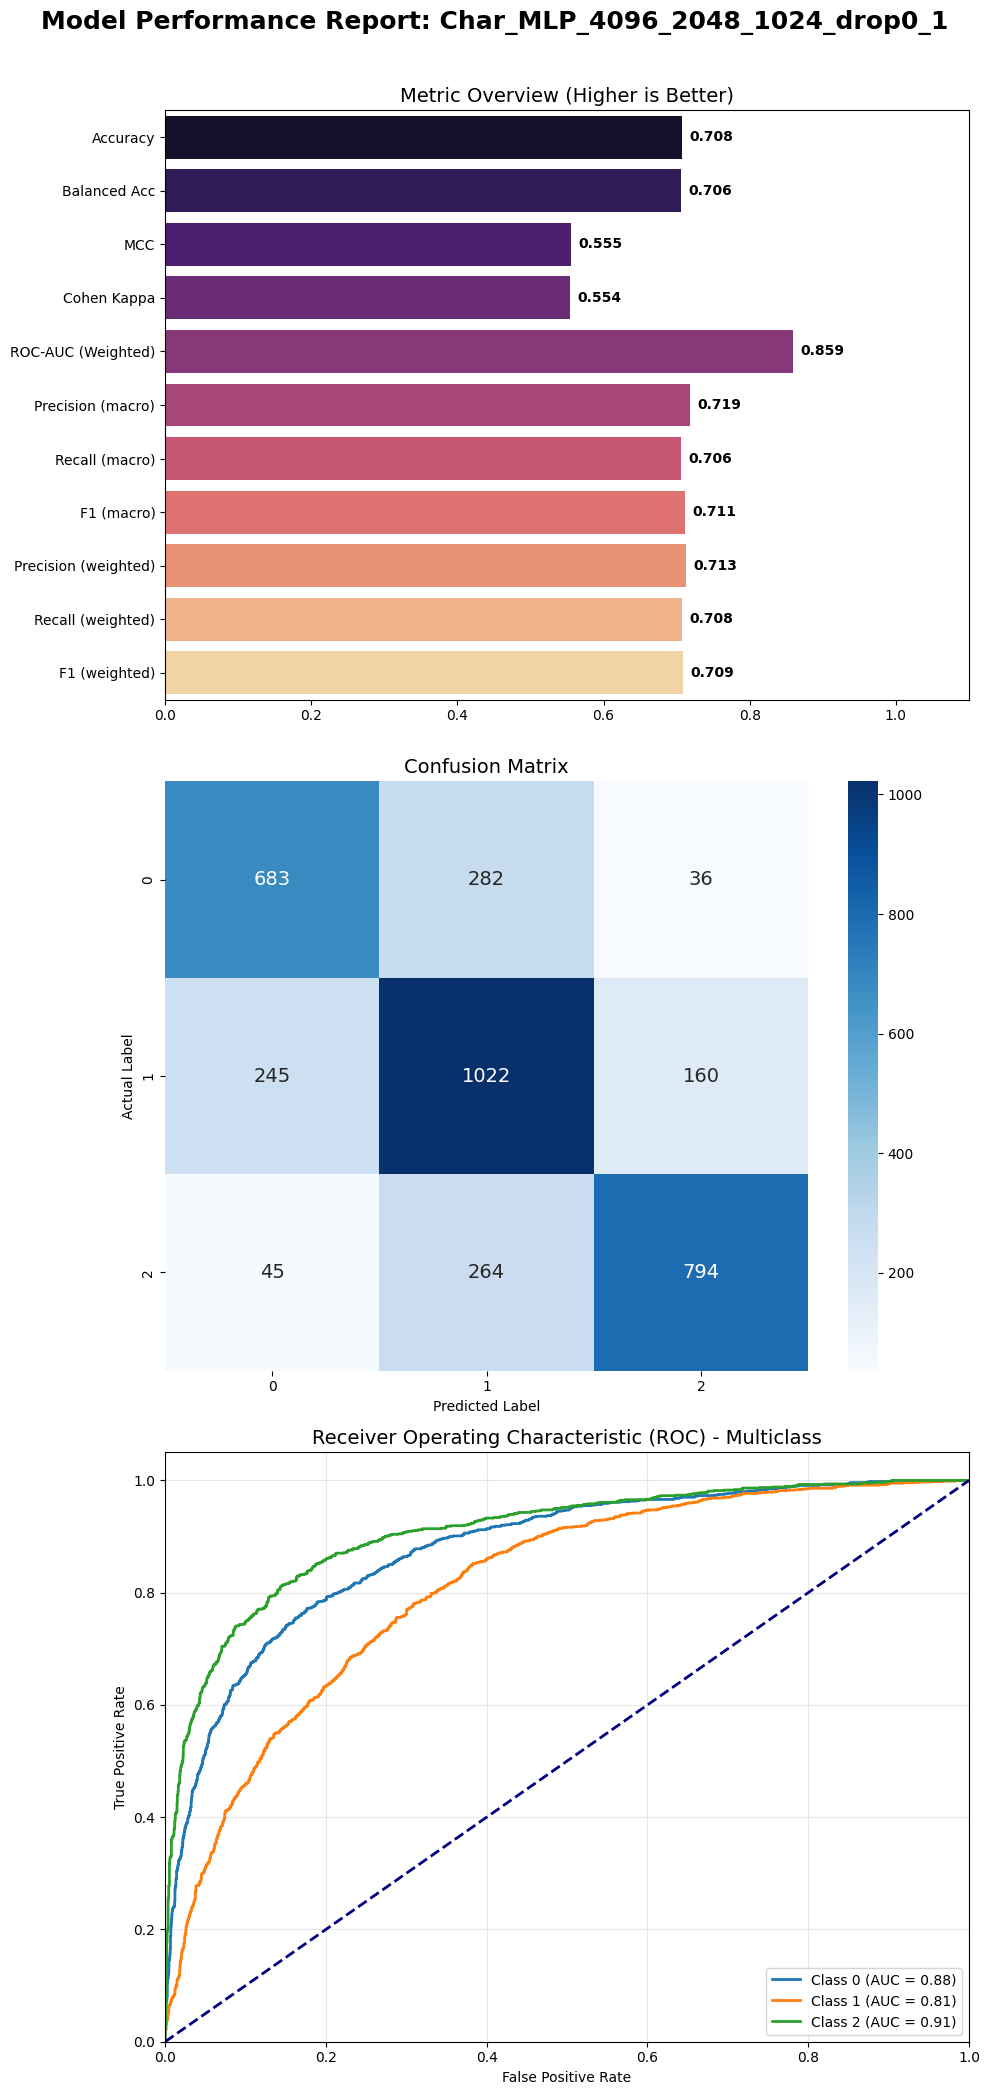

In [48]:
yt_true, yt_pred, yt_probs = predict_proba(model4, test_loader,device)

evaluate_model(
    y_true=yt_true,
    y_pred=yt_pred,
    y_probs=yt_probs,
    model_name="Char_MLP_4096_2048_1024_drop0_1",
    output_path=str(report_dir),
)